C:\Users\Laptop\AppData\Local\Temp\ipykernel_21024\2771300950.py:89: RuntimeWarning: divide by zero encountered in log
  fwdswapval_sim[i, j, k + 1] = - np.log(df_sim[i, j, k + 1] / df_sim[i, j, k]) / 0.25


0, 36155, 37890, 39692, 40270, 42111, 42801, 43496, 45398, 44765, 45151, 45082, 45570, 45212, 44552, 44133, 43473, 43040, 42717, 42153, 41187, 39550, 38449, 37006, 35391, 33719, 31944, 29961, 27125, 24735, 22291, 19822, 17191, 14767, 12084, 9293, 6225, 0, 0, 0, 0


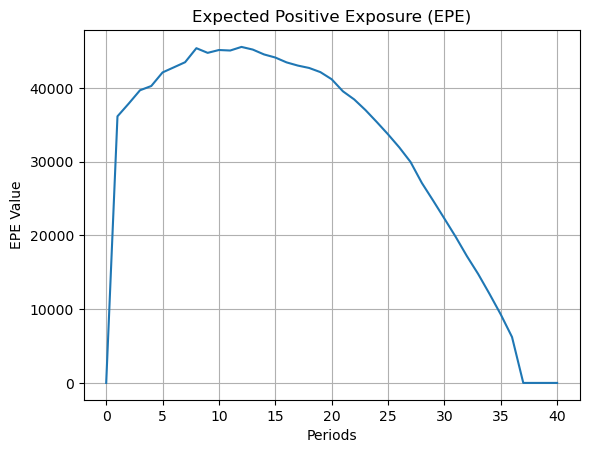

0, -1473, -3707, -6209, -8612, -10568, -11174, -11756, -12571, -13446, -13601, -14297, -14087, -14527, -15017, -14672, -14871, -14851, -14347, -14137, -13233, -13084, -12982, -12369, -11770, -11208, -10674, -9907, -8930, -8167, -7287, -6492, -5673, -4739, -3940, -2915, -1954, -3680, 0, 0, 0


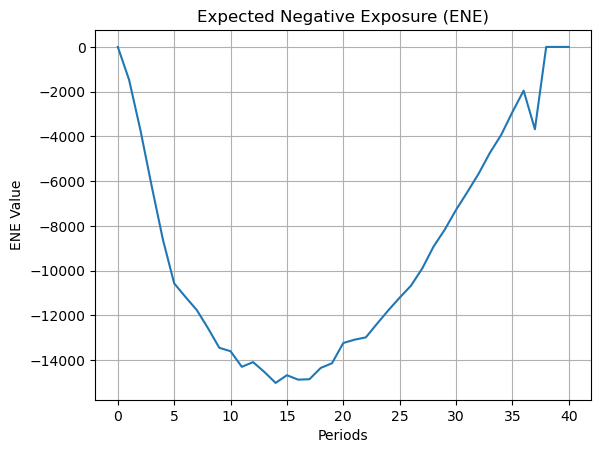

In [15]:
#HW implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

t = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 20]
zero_curve = [0.008, 0.0085, 0.0092, 0.01,  0.0106, 0.0119, 0.0132, 0.015, 0.02]

sig = 0.01
a = 0.1
fixed_rate = 0.0149
Notional = 1000000

timesteps = np.arange(0, 10.25, 0.25)

#print(len(timesteps))

cs = CubicSpline(t, zero_curve)
spot_rate = cs(timesteps)
df = np.exp(- timesteps * spot_rate)

#print(df)

dt = np.zeros(len(timesteps))
fwd = np.zeros(len(timesteps))
beta = np.zeros(len(timesteps))
B = np.zeros(len(timesteps))
fwdswapval = np.zeros(len(timesteps))

fwd[0] = spot_rate[0]
for i in range(1, len(timesteps)):
    dt[i] = timesteps[i] - timesteps[i - 1]
    fwd[i] = -np.log(df[i]/df[i - 1])/dt[i]
    beta[i] = fwd[i] + (sig * (1 - np.exp(-a *  timesteps[i]))/ (a * np.sqrt(2)))**2
    B[i] = (1 - np.exp(-a * timesteps[i])) / a
    

for i in range(1, len(timesteps) ):
    fwdswapval[i -1] = np.sum(df[i:len(timesteps)] * dt[i - 1] * fixed_rate) - (df[i - 1] - df[len(timesteps) - 1])
    
df_calib = np.zeros((len(timesteps), len(timesteps)))

for i in range(len(timesteps)):
    for j in range(i, len(timesteps)):
        df_calib[i, j] = df[j] / df[i] * np.exp(B[j - i] * fwd[i] - (sig ** 2) * (1 - np.exp(-2 * a * timesteps[i])) * (B[j - i] ** 2) / 4 *a)
        
#print(df_calib)

param1 = np.exp(-a * 0.25)  # 0.25 should be dt[i] 
param2 = np.sqrt((1 - np.exp(-2 * a * 0.25))/(2 * a)) #again hard coded dt

#print(param1, param2)

short_rate = np.zeros(len(timesteps) - 1)

sims = 1000

df_sim = np.zeros((sims, len(timesteps) - 1, len(timesteps) - 1))

short_rate[0] = spot_rate[0]
for k in range(len(timesteps) - 1):
    df_sim[:, 0, k] = df_calib[0, k] * np.exp(- B[k + 1] * short_rate[0])
    #print(B[k + 1])
    #print(short_rate[0])
    
df_sim[:, 0, 0] = 1

MtM = np.zeros((sims, len(timesteps)))

fwdswapval_sim = np.zeros((sims, len(timesteps) - 1, len(timesteps) - 1)) 

for i in range(sims):
    for j in range(1, len(timesteps) - 1):
        sumfxd = 0
        sumflt = 0
        z1 = np.random.normal(0,1)
        short_rate[j] = short_rate[j - 1] * param1 + z1 * sig * param2 + beta[j] - beta[j - 1] * param1
        for k in range(len(timesteps) - 2):
            df_sim[i,  j,  k] = df_calib[j, k] * np.exp(- B[k + 1 - j] * short_rate[j])
            df_sim[i, j, j] = 1
        
        for k in range(len(timesteps) - 1):
             fwdswapval_sim[i, j -1, k - 1] = np.sum(df_sim[i, j:len(timesteps)] * dt[j - 1] * fixed_rate) - (df[j - 1] - df[len(timesteps) - 1])
        
        for k in range(j,  len(timesteps)  - 2):
            if df_sim[i, j, k] != 0:
                fwdswapval_sim[i, j, k + 1] = - np.log(df_sim[i, j, k + 1] / df_sim[i, j, k]) / 0.25
            else:
                fwdswapval_sim[i, j, k + 1] = 0
            
            sumfxd += 0.25 * fixed_rate * df_sim[i, j, k + 1] * Notional
            sumflt += 0.25 * fwdswapval_sim[i, j, k] * df_sim[i, j, k + 1] * Notional

        MtM[i, j] = sumflt - sumfxd

#print(MtM)
    
    
EPE = np.mean(np.where(MtM > 0, MtM, 0), axis=0)
EPE_rounded = np.round(EPE).astype(int)
formatted_EPE = ', '.join(map(str, EPE_rounded))
print(formatted_EPE)


plt.plot(range(len(timesteps)), EPE_rounded)  
plt.title('Expected Positive Exposure (EPE)')
plt.xlabel('Periods')
plt.ylabel('EPE Value')
plt.grid(True)
plt.show()

ENE = np.mean(np.where(MtM < 0, MtM, 0), axis=0)
ENE_rounded = np.round(ENE).astype(int)
formatted_ENE = ', '.join(map(str, ENE_rounded))
print(formatted_ENE)

plt.plot(range(len(timesteps)), ENE_rounded) 
plt.title('Expected Negative Exposure (ENE)')
plt.xlabel('Periods')
plt.ylabel('ENE Value')
plt.grid(True)
plt.show()

EPE_ENE = pd.DataFrame({'formatted_EPE' : EPE, 'formatted_ENE'})

#broadly correct - few bugs possibly 

